# Autoencoders

When training CNNs, one of the problems is that we need a lot of labeled data. In the case of image classification, we need to separate images into different classes, which is a manual effort.

However, we might want to use raw (unlabeled) data for training CNN feature extractors, which is called **self-supervised learning**. Instead of labels, we will use training images as both network input and output. The main idea of **autoencoder** is that we will have an **encoder network** that converts input image into some **latent space** (normally it is just a vector of some smaller size), then the **decoder network**, whose goal would be to reconstruct the original image.

Since we are training autoencoder to capture as much of the information from the original image as possible for accurate reconstruction, the network tries to find the best **embedding** of input images to capture the meaning.


Most of the examples below are inspired by [this article](https://blog.keras.io/building-autoencoders-in-keras.html).

Let's create simplest autoencoder for MNIST:

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_trainclass), (x_test, y_testclass) = mnist.load_data()

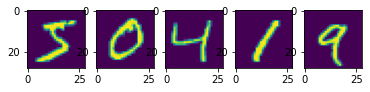

In [2]:
def plotn(n,x):
  fig,ax = plt.subplots(1,n)
  for i,z in enumerate(x[0:n]):
    ax[i].imshow(z.reshape(28,28) if z.size==28*28 else z.reshape(14,14) if z.size==14*14 else z)
  plt.show()
  
plotn(5,x_train)

In [3]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy,mse

# encoder
input_img = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

encoder = Model(input_img,encoded)

# decoder
input_rep = Input(shape=(4,4,8))
x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_rep)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(input_rep,decoded)

autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [5]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [131]:
autoencoder.fit(x_train, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
59648/60000 [============================>.] - ETA: 0s - loss: 0.2134

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 6s 99us/sample - loss: 0.2130 - val_loss: 0.1454
Epoch 2/25
60000/60000 [==============================] - 5s 86us/sample - loss: 0.1353 - val_loss: 0.1258
Epoch 3/25
60000/60000 [==============================] - 5s 87us/sample - loss: 0.1225 - val_loss: 0.1177
Epoch 4/25
60000/60000 [==============================] - 5s 85us/sample - loss: 0.1163 - val_loss: 0.1126
Epoch 5/25
60000/60000 [==============================] - 5s 87us/sample - loss: 0.1120 - val_loss: 0.1091
Epoch 6/25
60000/60000 [==============================] - 5s 86us/sample - loss: 0.1093 - val_loss: 0.1070
Epoch 7/25
60000/60000 [==============================] - 5s 87us/sample - loss: 0.1072 - val_loss: 0.1055
Epoch 8/25
60000/60000 [==============================] - 5s 87us/sample - loss: 0.1057 - val_loss: 0.1041
Epoch 9/25
60000/60000 [==============================] - 5s 85us/sample - loss: 0.1045 - val_loss: 0.1028
Epoch 10/25
60000/60000 [=======================

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


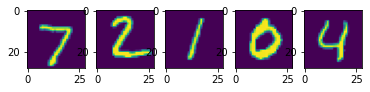

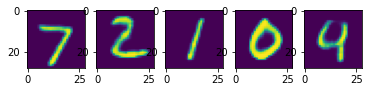

In [132]:
y_test = autoencoder.predict(x_test[0:5])
plotn(5,x_test)
plotn(5,y_test)

In [133]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test[0:5])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


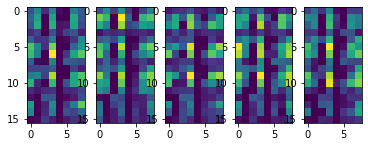

In [134]:
plotn(5,encoded_imgs.reshape(5,-1,8))

6.3110805 0.0


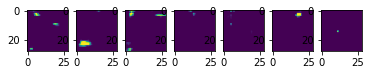

In [136]:
print(encoded_imgs.max(),encoded_imgs.min())
res = decoder.predict(7*np.random.rand(7,4,4,8))
plotn(7,res)

## Denoising

Autoencoders can be effectively used to remove noise from images. In order to train denoiser, we will start with noise-free images, and add artificial noise to them. Then, we will feed autoencoder with noisy images as input, and noise-free images as output.

Let's see how this works for MNIST:

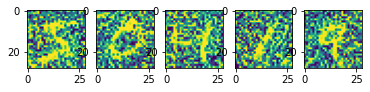

In [137]:
def noisify(data):
  return np.clip(data+np.random.normal(loc=0.5,scale=0.5,size=data.shape),0.,1.)

x_train_noise = noisify(x_train)
x_test_noise = noisify(x_test)

plotn(5,x_train_noise)

In [141]:
autoencoder.fit(x_train_noise, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noise, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 6s 101us/sample - loss: 0.1576 - val_loss: 0.1566
Epoch 2/25
60000/60000 [==============================] - 6s 95us/sample - loss: 0.1564 - val_loss: 0.1553
Epoch 3/25
60000/60000 [==============================] - 6s 94us/sample - loss: 0.1555 - val_loss: 0.1539
Epoch 4/25
60000/60000 [==============================] - 6s 95us/sample - loss: 0.1545 - val_loss: 0.1530
Epoch 5/25
60000/60000 [==============================] - 6s 95us/sample - loss: 0.1538 - val_loss: 0.1517
Epoch 6/25
60000/60000 [==============================] - 6s 93us/sample - loss: 0.1528 - val_loss: 0.1506
Epoch 7/25
60000/60000 [==============================] - 6s 93us/sample - loss: 0.1521 - val_loss: 0.1499
Epoch 8/25
60000/60000 [==============================] - 5s 92us/sample - loss: 0.1514 - val_loss: 0.1495
Epoch 9/25
60000/60000 [==============================] - 6s 92us/sample - loss: 0.1508 - val

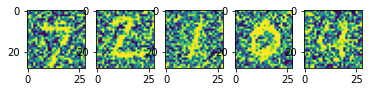

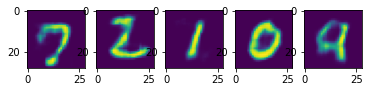

In [144]:
y_test = autoencoder.predict(x_test_noise[0:5])
plotn(5,x_test_noise)
plotn(5,y_test)

## Super-resolution

Similarly to denoiser, we can train autoencoders to increase the resolution of the image. To train super-resolution network, we will start with high-resolution images, and automatically downscale them to produce network inputs. We will then feed autoencoder with small images as inputs and high-res images as outputs.

Let's downscale MNIST to 14x14:

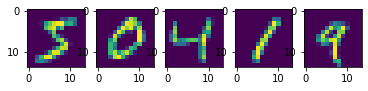

In [6]:
x_train_lr = tf.keras.layers.AveragePooling2D()(x_train).numpy()
x_test_lr = tf.keras.layers.AveragePooling2D()(x_test).numpy()
plotn(5,x_train_lr)

In [7]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy,mse

# encoder
input_img = Input(shape=(14, 14, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

encoder = Model(input_img,encoded)

# decoder
input_rep = Input(shape=(4,4,8))
x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_rep)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(input_rep,decoded)

autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [8]:
autoencoder.fit(x_train_lr, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_lr, x_test))

Epoch 1/25
469/469 [==============================] - 6s 10ms/step - loss: 0.3413 - val_loss: 0.1519
Epoch 2/25
469/469 [==============================] - 4s 9ms/step - loss: 0.1457 - val_loss: 0.1292
Epoch 3/25
469/469 [==============================] - 4s 9ms/step - loss: 0.1273 - val_loss: 0.1202
Epoch 4/25
469/469 [==============================] - 4s 9ms/step - loss: 0.1189 - val_loss: 0.1142
Epoch 5/25
469/469 [==============================] - 4s 9ms/step - loss: 0.1148 - val_loss: 0.1107
Epoch 6/25
469/469 [==============================] - 4s 9ms/step - loss: 0.1115 - val_loss: 0.1083
Epoch 7/25
469/469 [==============================] - 4s 9ms/step - loss: 0.1093 - val_loss: 0.1063
Epoch 8/25
469/469 [==============================] - 4s 9ms/step - loss: 0.1071 - val_loss: 0.1046
Epoch 9/25
469/469 [==============================] - 4s 9ms/step - loss: 0.1060 - val_loss: 0.1037
Epoch 10/25
469/469 [==============================] - 4s 9ms/step - loss: 0.1048 - val_loss: 0.102

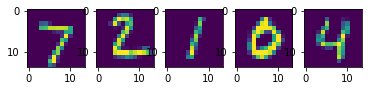

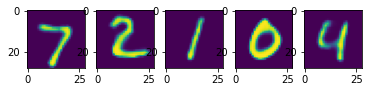

In [9]:
y_test_lr = autoencoder.predict(x_test_lr[0:5])
plotn(5,x_test_lr)
plotn(5,y_test_lr)